# Fraud Detection using XGBoost on Amazon SageMaker

**Note. This notebook should be used with the Python 3 (Data Science) kernel.**

* An end to end pipeline to train a fraud detection model using xgboost. 

* Hyper-Parameter Optimization (HPO) for xgboost.

In [ ]:
# Add the path to the sagemaker_fraud_detection package to the system path
import sys
import uuid
import os

sys.path.append("./sagemaker_fraud_detection/")

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

import boto3
import sagemaker
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader

from data_preprocessing.utils import get_data, print_metrics, plot_cm, plot_prc
from sagemaker_fraud_detection import config

role = config.role
sess = sagemaker.Session()

print(f"Execution role {role}")
print(f"SageMaker session {sess}")

Execution role arn:aws:iam::722696965592:role/service-role/AmazonSageMaker-ExecutionRole-20230116T171380
SageMaker session <sagemaker.session.Session object at 0x7f077be27f40>


## Dataset and Problem Statement

### Generate Synthetic Data

The dataset for this project will be generated using the [Faker](https://faker.readthedocs.io/en/master/) package. The script for generating the data is contained in the `data_generation` directory. The dataset is created to mimic typical examples of financial transactions dataset that many companies have. The dataset consists of two tables:

* **Transactions** table: Records transactions and metadata about transactions between two users. Examples of columns include the product code for the transaction and features on the card used for the transaction, and a column indicating whether the corresponded transcation is fraud or not.

* **Identity** table: Contains information about the identity users performing transactions. Examples of columns here include the device type and device ids used.

The two tables can be joined together using the unique identified-key column **TransactionID**.

In [2]:
!mkdir -p raw_data
!pip3 install faker
!python3 data_generation/generate_data.py

if os.path.exists("raw_data/transaction.csv") and os.path.exists(
    "raw_data/identity.csv"
):
    print("Data is successfully generated!")

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.3 MB/s eta 0:00:0000:01
fraud ratio 0.14157773711975055
Data is successfully generated!


### Upload raw data to S3

Move the raw data from local directory `raw_data` to S3 bucket for this project, where it will be picked up by the preprocessing job and training job.

In [3]:
# Raw data location
raw_data_location = "raw_data/"

# Target s3 bucket
config.s3_prefix
s3_raw_data_location = f"s3://{config.s3_bucket}/{config.s3_prefix}/raw_data/"

# Copy local raw data to s3 bucket
!aws s3 cp --recursive $raw_data_location $s3_raw_data_location

# Set s3 locations to store processed data for training and post-training results and artifacts respectively
train_data = f"s3://{config.s3_bucket}/{config.s3_prefix}/{config.s3_processing_output}"
train_output = f"s3://{config.s3_bucket}/{config.s3_prefix}/{config.s3_train_output}"

upload: raw_data/identity.csv to s3://yang-ml-sagemaker/fraud_detection_project/raw_data/identity.csv
upload: raw_data/transaction.csv to s3://yang-ml-sagemaker/fraud_detection_project/raw_data/transaction.csv


In [3]:
print(f"Processed data will be stored at {train_data}")
print(f"Training output path will be {train_output}")

Processed data will be stored at s3://yang-ml-sagemaker/fraud_detection_project/preprocessed_data
Training output path will be s3://yang-ml-sagemaker/fraud_detection_project/training_output


### Features

Read the tables of transaction.csv and identity.csv and merge them based on the `TransactionID` column.

Besides the unique identifier column (**TransactionID**) to identify each transaction, there are two types of feature columns and one target column.

* **Identity columns** that contain identity information related to a transaction. The corresponded columns include **card_no**, **card_type**, **email_domain**, **IpAddress**, **PhoneNo**, **DeviceID**. Note that there may be missing values since some transactions do not have values these identity columns. This is so that the data set mimics real world data.

* **Categorical or numerical columns** that describes the features of each transaction. The corresponded columns include **ProductCD** and **TransactionAmt**.

* Target column **isFraud**.

The **goal** is to fully utilize the information in the feature columns to classify each transaction (each row in the table) either as fraud or not fraud.

In [4]:
transactions_df = pd.read_csv(os.path.join(raw_data_location, "transaction.csv"))
identity_df = pd.read_csv(os.path.join(raw_data_location, "identity.csv"))

The first 5 observations in transaction dataset.

In [5]:
transactions_df.head(5)

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud
0,9c90c7e2-2600-4628-a868-179287eee169,2012-01-15 00:00:20,30545481171260,JCB 16 digit,smith-henry.info,T,1198,0
1,02951e68-f8ff-4f00-b515-5df8bcb0edcb,2012-01-15 00:00:44,6549624810102543,VISA 13 digit,yahoo.com,Y,409,0
2,17071ccd-3c3d-476a-a3cd-b73638a803d4,2012-01-15 00:02:18,4792410992636220,JCB 15 digit,hotmail.com,Y,1101,0
3,5288f832-6673-473a-80f6-fdb98dd99278,2012-01-15 00:03:01,3573503852773765,VISA 16 digit,hotmail.com,Y,2228,0
4,e37a6dd1-182e-4b87-8b8e-7dd9bf78cea0,2012-01-15 00:03:24,3597910599495184,Diners Club / Carte Blanche,gmail.com,L,2393,0


The first 5 observations in identity dataset.

In [6]:
identity_df.head(5)

,TransactionID,IpAddress,PhoneNo,DeviceID
0,f9980c5d-e8bf-4431-9ddf-15b4e7a9d7ff,104.32.122.67,7993004217,657817920030
1,011955b3-14fa-4342-85f4-3a9c3759b7d7,164.180.250.14,6712423669,8984812524268
2,a61677ac-a0cb-4113-9409-87bcfe7e6e44,99.31.120.70,+1-353-046-6749x00004,3092060466768
3,f46e41fc-5d06-4f60-b730-a5d7ecec90f1,10.225.43.49,125-534-6633x1775,2516617099683
4,4cc7b6f5-9579-4149-80d8-8cb6c807ee6c,218.46.8.47,(374)448-9917,7683358940269


Join the two datasets using the **TransactionID** column.

In [7]:
full_identity_df = transactions_df.merge(identity_df, on="TransactionID", how="left")

# Drop transcations time column as it is not useful for modeling
full_identity_df.drop(["TransactionDT"], axis=1, inplace=True)

# Re-arange the order of column names for better visualization
full_identity_df = full_identity_df[
    [
        "TransactionID",
        "card_no",
        "card_type",
        "email_domain",
        "IpAddress",
        "PhoneNo",
        "DeviceID",
        "ProductCD",
        "TransactionAmt",
        "isFraud",
    ]
]
full_identity_df.head(5)

,TransactionID,card_no,card_type,email_domain,IpAddress,PhoneNo,DeviceID,ProductCD,TransactionAmt,isFraud
0,9c90c7e2-2600-4628-a868-179287eee169,30545481171260,JCB 16 digit,smith-henry.info,121.92.230.58,+1-038-395-3162x55186,7.163249e+12,T,1198,0
1,02951e68-f8ff-4f00-b515-5df8bcb0edcb,6549624810102543,VISA 13 digit,yahoo.com,118.244.38.209,001-923-541-7445x63231,3.807589e+12,Y,409,0
2,17071ccd-3c3d-476a-a3cd-b73638a803d4,4792410992636220,JCB 15 digit,hotmail.com,66.25.190.213,955-326-1614,9.673129e+12,Y,1101,0
3,5288f832-6673-473a-80f6-fdb98dd99278,3573503852773765,VISA 16 digit,hotmail.com,42.93.10.194,+1-339-892-9034x139,9.965894e+12,Y,2228,0
4,e37a6dd1-182e-4b87-8b8e-7dd9bf78cea0,3597910599495184,Diners Club / Carte Blanche,gmail.com,154.168.168.7,278.713.5654,7.523612e+12,L,2393,0


Since we generated data where the 'Identity' table contains fewer observations than the 'Transactions' table, there will be missing values in some of the columns after we left joined the 'Identity' table onto the 'Transactions' table.

In [8]:
full_identity_df.isna().sum(axis=0)

TransactionID         0
card_no               0
card_type             0
email_domain          0
IpAddress         28094
PhoneNo           28094
DeviceID          28094
ProductCD             0
TransactionAmt        0
isFraud               0
dtype: int64

Distribution of the target column:

In [9]:
print(
    f"The target column has the following distribution: \n {full_identity_df.isFraud.value_counts() / full_identity_df.shape[0]}"
)

The target column has the following distribution: 
 0    0.858422
1    0.141578
Name: isFraud, dtype: float64


## Data Preprocessing and Feature Engineering

### Run Preprocessing job with Amazon SageMaker Processing

The script defined in `data-preprocessing/data_preprocessor.py` performs data preprocessing and feature engineering transformations on the raw data. Some of the data transformation and feature engineering techniques include:

* Performing numerical encoding for categorical variables and logarithmic transformation for transaction amount

The inputs to the data preprocessing script are passed in as python command line arguments. All the columns in the relational table are classifed into one of 3 types for the purposes of data transformation: 

* **Identity columns** `--id-cols`: columns that contain identity information related to a user or transaction for example IP address, Phone Number, device identifiers etc.

* **Categorical columns** `--cat-cols`: columns that correspond to categorical features for a user's age group or whether a provided address matches with an address on file. The entries in these columns undergo numerical feature transformation. The columns names for these column types also needs to be passed in to the script

* **Numerical columns**: columns that correspond to numerical features like how many times a user has tried a transaction and so on. The script assumes that all columns in the tables that are not identity columns or categorical columns are numerical columns

The datasets are divided into training (70% of the entire data), validation (20%), and test datasets (10%). The validation dataset are used for hyper-parameter optimization to select the optimal set of hyper-parameters. And the test dataset is used for the final evaluation to compare various models.

The `SKLearnProcessor` handles Amazon SageMaker processing tasks for jobs using scikit-learn. Then, we can use logic and functions defined in the `data-preprocessing/data_preprocessor.py` script in a processing job by calling the `run` method on the `SKLearnProcessor` instance. The `run` method requires the following arguments:

* `code`: An S3 URI or a local path to a file with the framework script to run

* `inputs`: Input files for the processing job. These must be provided as `sagemaker.processing.ProcessingInput` objects

* `outputs`: Outputs for the processing job. These can be specified as either path strings or `sagemaker.processing.ProcessingOutput` objects

* `arguments`: A list of string arguments to be passed to a processing job, which will be parsed by the script provided to `code`

In [12]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from time import strftime, gmtime

# Timestamp
time_stamp = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Processing job name
processing_job_name = f"sagemaker-fraud-detection-processing-job-{time_stamp}"

# Instantiate processor
sklearn_processor = SKLearnProcessor(
    framework_version="0.20.0",  # Scikit-learn version
    role=role,  # AWS IAM role name
    instance_type="ml.m5.xlarge",  # Type of EC2 instance to use for processing (4 vCPU's and 16 GiB of memory)
    instance_count=1,  # Number of instances to run the processing job with
    base_job_name=processing_job_name,
)

# Run processor
sklearn_processor.run(
    code="data_preprocessing/data_preprocessor.py",
    inputs=[
        ProcessingInput(
            source=s3_raw_data_location, destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(destination=train_data, source="/opt/ml/processing/output")
    ],
    arguments=[
        "--cat-cols-xgboost",
        "card_type,ProductCD",  # Categorical columns for xgboost
    ],
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating processing-job with name sagemaker-fraud-detection-processing-jo-2023-03-18-12-40-41-761


........................../miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
2023-03-18 12:44:51,697 INFO __main__: Shape of transaction data is (140467, 8)
2023-03-18 12:44:51,698 INFO __main__: # Tagged transactions: 140467
2023-03-18 12:44:51,915 INFO __main__: Shape of identity data is (112373, 4)
2023-03-18 12:44:51,915 INFO __main__: Training, validation, and test data fraction are 0.7, 0.2, and 0.10000000000000003, respectively
2023-03-18 12:44:52,074 INFO __main__: Percentage of fraud transactions for train data: 14.158005003762993
2023-03-18 12:44:52,099 INFO 

### View Results of Data Preprocessing

Once the preprocessing job is complete, we can take a look at the contents of the S3 bucket to see the transformed data.

In [4]:
processed_files = S3Downloader.list(train_data)
print("===== Processed Files =====")
print("\n".join(processed_files))

# Download processed data into local directory preprocessed_data
S3Downloader.download(
    train_data, train_data.split("/")[-1]
)  # Use -1 to obtain the last substring of the path

===== Processed Files =====
s3://yang-ml-sagemaker/fraud_detection_project/preprocessed_data/features_xgboost.csv
s3://yang-ml-sagemaker/fraud_detection_project/preprocessed_data/tags.csv
s3://yang-ml-sagemaker/fraud_detection_project/preprocessed_data/test.csv
s3://yang-ml-sagemaker/fraud_detection_project/preprocessed_data/validation.csv


## XGBoost

We train an XGBoost model with HPO (Hyperparameter Optimization) on the transaction table data. 

### Read data and upload to S3
The features used for training XGBoost are from **features_xgboost.csv** that are processed in the above processing job. 

The features include categorical columns **productCD**, **card_type** and numerical column **TransactionAmt**. 

The categorical features are onehot encoded. Other features (categorical features) such as **IpAddress**, **PhoneNO** contain too many categories (~40,000) and thus are not suitable to be used as training features for XGBoost.

In [6]:
train_data_df, valid_data_df, test_data_df = get_data()

Let's check the first 5 observations of the train data frame.

In [7]:
train_data_df.head(5)

,isFraud,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
TransactionID,,,,,,,,,,,,,,,,,
9c90c7e2-2600-4628-a868-179287eee169,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3.078457
02951e68-f8ff-4f00-b515-5df8bcb0edcb,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.611723
5288f832-6673-473a-80f6-fdb98dd99278,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.347915
e37a6dd1-182e-4b87-8b8e-7dd9bf78cea0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3.378943
9e94c1be-5186-4769-badd-6e43d344150b,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2.247973


Save the training and validation data into local directory and then upload them to s3 bucket for training.

In [8]:
!mkdir -p xgboost_input
train_data_df.to_csv("xgboost_input/train_xgb.csv", header=False, index=False)
valid_data_df.to_csv("xgboost_input/validation_xgb.csv", header=False, index=False)

In [9]:
xgboost_prefix = "xgboost_fraud_detection"

s3_train_data = S3Uploader.upload(
    "xgboost_input/train_xgb.csv",
    f"s3://{config.s3_bucket}/{config.s3_prefix}/{xgboost_prefix}/train",
)
print(f"Uploaded training data location: {s3_train_data}")

s3_validation_data = S3Uploader.upload(
    "xgboost_input/validation_xgb.csv",
    f"s3://{config.s3_bucket}/{config.s3_prefix}/{xgboost_prefix}/validation",
)
print(f"Uploaded training data location: {s3_validation_data}")

output_location = f"s3://{config.s3_bucket}/{config.s3_prefix}/{xgboost_prefix}/output"
print(f"Training artifacts are uploaded to: {output_location}")

Uploaded training data location: s3://yang-ml-sagemaker/fraud_detection_project/xgboost_fraud_detection/train/train_xgb.csv
Uploaded training data location: s3://yang-ml-sagemaker/fraud_detection_project/xgboost_fraud_detection/validation/validation_xgb.csv
Training artifacts are uploaded to: s3://yang-ml-sagemaker/fraud_detection_project/xgboost_fraud_detection/output


### Train SageMaker XGBoost Estimator with HPO

Moving onto training, first we need to specify the locations of the XGBoost algorithm containers.

In [10]:
import boto3
from sagemaker.inputs import TrainingInput

# Retrieve the latest xgboost docker image
container = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="latest"
)
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

Because we're training with CSV file format, we create `TrainingInputs` that our training function can use as a pointer to the files in S3.

In [11]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{config.s3_bucket}/{config.s3_prefix}/{xgboost_prefix}/train",
    content_type="csv",
)
s3_input_validation = TrainingInput(
    s3_data=f"s3://{config.s3_bucket}/{config.s3_prefix}/{xgboost_prefix}/validation",
    content_type="csv",
)

The `sagemaker.estimator.Estimator` class is a generic `Estimator` used to train using any supplied algorithm. This class is designed for use with algorithms that don’t have their own, custom class. Some key arguments are:

* image_uri (str or `PipelineVariable`): The container image to use for training.

* `role` (str): An AWS IAM role (either name or full ARN).

* `instance_count` (int or `PipelineVariable`): Number of Amazon EC2 instances to use for training.

* `instance_type` (str or `PipelineVariable`): Type of EC2 instance to use for training, for example, 'ml.c4.xlarge'. 

* `output_path` (int or `PipelineVariable`): S3 location for saving the training result (model artifacts and output files).

* `sagemaker_session`: Session object which manages interactions with Amazon SageMaker APIs and any other AWS services needed.

In [12]:
# Import hyperparameter sampler and configuration class
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# The first column is the target
train_y = train_data_df.values[:, 0]
# Scale positive class weight using the ratio of negative class to positive class
scale_pos_weight = (len(train_y) - sum(train_y)) / sum(train_y)

# Estimator for training
xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)

# Hyperparameter for xgboost
xgb.set_hyperparameters(
    eval_metric="auc",  # Evaluation metrics for validation data
    objective="binary:logistic",  # Objective function
    num_round=1000,  # Number of boosting rounds (trees)
    early_stopping_rounds=10,  # Early stopping
    silent=0,
    scale_pos_weight=scale_pos_weight,  # Scale positive class
)

# We wish to tune the hyperparmeters based on validation 'auc' and not training 'auc'
objective_metric_name = "validation:auc"
objective_type = "Maximize"

Next, we define the hyperparameter search space:

In [13]:
# Define the hyper-parameters search ranges
hyperparameter_ranges = {
    "eta": ContinuousParameter(
        0, 1
    ),  # Learning rate, the higher the more conservative boosting process (regularizer)
    "min_child_weight": ContinuousParameter(
        1, 10
    ),  # The larger min_child_weight is, the more conservative the algorithm will be (regularizer)
    "gamma": ContinuousParameter(
        0, 0.6
    ),  # Range: [0, inf], the larger the more conservative the algorithm (regularizer)
    "alpha": ContinuousParameter(
        0, 2
    ),  # Range: [0, inf], L1 regularization term on weights, the larger the more conservative the algorithm (regularizer)
    "max_depth": IntegerParameter(
        1, 10
    ),  # Range: [0, inf], deep trees boost predictive power but are more likely to overfit (bias reducer)
    "subsample": ContinuousParameter(
        0.2, 1
    ),  # Range: (0, 1], subsample ratio of the training instances every boosting iteration, the smaller the more conservative (regularizer)
}

The `sagemaker.tuner.HyperparameterTuner` class takes an `estimator` to obtain configuration information for training jobs, which are created as the result of a hyperparameter tuning job. Some key arguments are:

- `estimator` (`sagemaker.estimator.EstimatorBase`) - An estimator object that has been initialized with the desired configuration. There does not need to be a training job associated with this instance.

- `objective_metric_name` (str or `PipelineVariable`) - Name of the metric for evaluating training jobs.

- `hyperparameter_ranges` (`dict[str, sagemaker.parameter.ParameterRange]`) Dictionary of parameter ranges. These parameter ranges can be one of three types: Continuous, Integer, or Categorical. The keys of the dictionary are the names of the hyperparameter, and the values are the appropriate parameter range class to represent the range.

- `metric_definitions` (`list[dict[str, str]` or `list[dict[str, PipelineVariable]]`) - A list of dictionaries that defines the metric(s) used to evaluate the training jobs (default: None). Each dictionary contains two keys: 'Name' for the name of the metric, and 'Regex' for the regular expression used to extract the metric from the logs. This should be defined only for hyperparameter tuning jobs that don't use an Amazon algorithm.

- `strategy` (str or `PipelineVariable`) - Strategy to be used for hyperparameter estimations (default: 'Bayesian').

- `objective_type` (str or `PipelineVariable`) - The type of the objective metric for evaluating training jobs. This value can be either 'Minimize' or 'Maximize' (default: 'Maximize').

- `max jobs` (int or `PipelineVariable`) - Maximum total number of training jobs to start for the hyperparameter tuning job. The default value is unspecified fot the GridSearch strategy and the default value is 1 for all others

- `max_parallel_jobs` (int or `PipelineVariable`) - Maximum number of parallel training jobs to start (default: 1 ).

- `early_stopping_type` (str or `PipelineVariable`) - Specifies whether early stopping is enabled for the job. Can be either 'Auto' or 'Off' (default: 'Off'). If set to 'Off', early stopping will not be attempted. If set to 'Auto', early stopping of some training jobs may happen, but is not guaranteed to.

- `random_seed` (int) - An initial value used to initialize a pseudo-random number generator. Setting a random seed will make the hyperparameter tuning search strategies to produce more consistent configurations for the same tuning job.

In [14]:
# Unique id for tuning job
unique_hash = str(uuid.uuid4())[:6]
tuning_job_name = f"sagemaker-fraud-detection-{unique_hash}-tuning-job"
print(
    f"We can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with {tuning_job_name} to monitor HPO tuning status and details.\n"
)

tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name=objective_metric_name,  # Tune based on validation 'auc'
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type=objective_type,  # Maximize auc
    strategy="Bayesian",  # Use Bayesian optimization
    max_jobs=30,  # Maximum total number of training jobs to start for hyperparameter tuning job
    max_parallel_jobs=3,  # Maximum number of parallel training jobs
    base_tuning_job_name=tuning_job_name,  # Tuning job name
    early_stopping_type="Off",  # By default, early stopping will not be attempted
)

# Train and Validation sets
tuner.fit(inputs={"train": s3_input_train, "validation": s3_input_validation})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


We can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with sagemaker-fraud-detection-143f5d-tuning-job to monitor HPO tuning status and details.

................................................................................................................!


Check the Status of HPO tuning jobs:

In [15]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

Retrieve the tuning job name

In [16]:
# Create a sagemaker client
sm_client = boto3.Session().client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'sagemaker-fraud-dete-230318-1208'

We can also obtain a description of a hyperparameter tuning job, stored in a **dictionary**, using the tunig job name:

In [17]:
# Tuning job results dictionary
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

# Number of training jobs completed
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

30 training jobs have completed


The `sagemaker.HyperparameterTuningJobAnalytics` class fetches results about a hyperparameter tuning job and makes them accessible for analytics.

In [18]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

full_df.sort_values("FinalObjectiveValue", ascending=False).head(5)

,alpha,eta,gamma,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
26,1.385862,0.718968,0.098785,6.0,4.915037,0.960143,sagemaker-fraud-dete-230318-1208-004-22e043a0,Completed,0.858585,2023-03-18 12:10:46+00:00,2023-03-18 12:11:08+00:00,22.0
28,1.752311,0.395842,0.595911,7.0,6.392295,0.885438,sagemaker-fraud-dete-230318-1208-002-6e851ad8,Completed,0.858363,2023-03-18 12:09:21+00:00,2023-03-18 12:10:38+00:00,77.0
11,1.372968,0.667018,0.079595,5.0,5.733988,0.959357,sagemaker-fraud-dete-230318-1208-019-19601532,Completed,0.858113,2023-03-18 12:15:02+00:00,2023-03-18 12:15:24+00:00,22.0
19,1.390263,0.661666,0.194786,6.0,4.246918,0.954406,sagemaker-fraud-dete-230318-1208-011-98d06817,Completed,0.858008,2023-03-18 12:12:36+00:00,2023-03-18 12:12:58+00:00,22.0
4,1.211909,0.549331,0.111055,6.0,6.389528,0.959456,sagemaker-fraud-dete-230318-1208-026-fed7d640,Completed,0.858004,2023-03-18 12:16:34+00:00,2023-03-18 12:16:56+00:00,22.0


### Deploy Endpoint of Best Tuning Job

The `deploy` method deploys the best trained or user specified model to an Amazon SageMaker endpoint, also returning a `sagemaker.Predictor` object. The `sagemaker.serializers.CSVSerializer` class serializez data of various formats to a CSV-formatted string.

In [19]:
from sagemaker.serializers import CSVSerializer
from sagemaker.predictor import Predictor

print(
    f"We can go to SageMaker -> Inference -> Endpoints --> an endpoint with name started with {tuning_job_name} to monitor the deployment status."
)

predictor_hpo = tuner.deploy(
    initial_instance_count=1,  # Minimum number of EC2 instances to deploy to an endpoint for prediction
    instance_type="ml.m5.xlarge",  # Type of EC2 instance to deploy to an endpoint for prediction
    serializer=CSVSerializer(),  # A serializer object, used to encode data for an inference endpoint
)

We can go to SageMaker -> Inference -> Endpoints --> an endpoint with name started with sagemaker-fraud-dete-230318-1208 to monitor the deployment status.

2023-03-18 12:11:25 Starting - Found matching resource for reuse
2023-03-18 12:11:25 Downloading - Downloading input data
2023-03-18 12:11:25 Training - Training image download completed. Training in progress.
2023-03-18 12:11:25 Uploading - Uploading generated training model
2023-03-18 12:11:25 Completed - Resource reused by training job: sagemaker-fraud-dete-230318-1208-006-6c1fe834
-----!

Define a function for predictions. The `sagemaker.predictor.Predictor` class returned by the `deploy` class instance above has a `predict` method:

- `data` (object) - Input data for which we want the model to provide inference. If a serializer was specified when creating the Predictor, the result of the serializer is sent as input data. Otherwise the data must be sequence of bytes, and the predict method then sends the bytes in the request body as is.

- `initial_args` (`dict[str,str]`) - Optional. Default arguments for boto3 invoke_endpoint call. Default is None (no default arguments).

- `target_model` (str) - S3 model artifact path to run an inference request on, in case of a multi model endpoint. Does not apply to endpoints hosting single model (Default: None)

- `target_variant` (str) - The name of the production variant to run an inference request on (Default: None). Note that the `ProductionVariant` identifies the model we want to host and the resources we want to deploy for hosting it.

- `inference_id` (str) - If we provide a value, it is added to the captured data when we enable data capture on the endpoint (Default: None).

In [20]:
def predict(
    current_predictor: Predictor, data: np.ndarray, rows: int = 500
) -> np.ndarray:
    # Create data for prediction
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join(
            [predictions, current_predictor.predict(array).decode("utf-8")]
        )
    return np.fromstring(predictions[1:], sep=",")


# Estimated probabilities for positive class
hpo_raw_preds = predict(
    predictor_hpo,
    test_data_df.values[:, 1:],  # Test data
)

# Convert probabilities to predictions
hpo_preds = np.where(hpo_raw_preds > 0.5, 1, 0)

### Evaluation on Test Set

In [24]:
result_xgboost_with_hpo = print_metrics(test_data_df.values[:, 0], hpo_preds)

fpr, tpr, _ = roc_curve(test_data_df.values[:, 0], hpo_raw_preds)
roc_auc = auc(fpr, tpr)
result_xgboost_with_hpo.append(roc_auc)
result_xgboost_with_hpo = pd.DataFrame(
    result_xgboost_with_hpo,
    index=["F1", "Precision", "Recall", "Accuracy", "ROC_AUC"],
    columns=["XGBoost_With_HPO"],
)

print(result_xgboost_with_hpo)

           XGBoost_With_HPO
F1                 0.583503
Precision          0.462126
Recall             0.791352
Accuracy           0.840037
ROC_AUC            0.847260


While precision is low (more false positives), we are able to increase recall (false negatives). In the context of fraud detection, the cost of false negative may be greater.

Legitimate Transactions Detected (True Negatives):  0.8480676729142478
Legitimate Transactions Incorrectly Detected (False Positives):  0.1519323270857522
Fraudulent Transactions Missed (False Negatives):  0.20864756158873807
Fraudulent Transactions Detected (True Positives):  0.7913524384112619
Total Fraudulent Transactions:  1.0


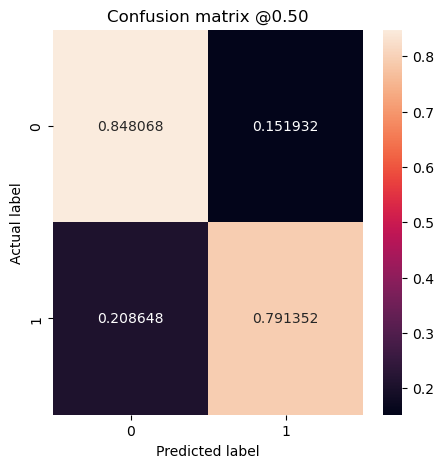

In [25]:
plot_cm(test_data_df.values[:, 0], hpo_raw_preds)

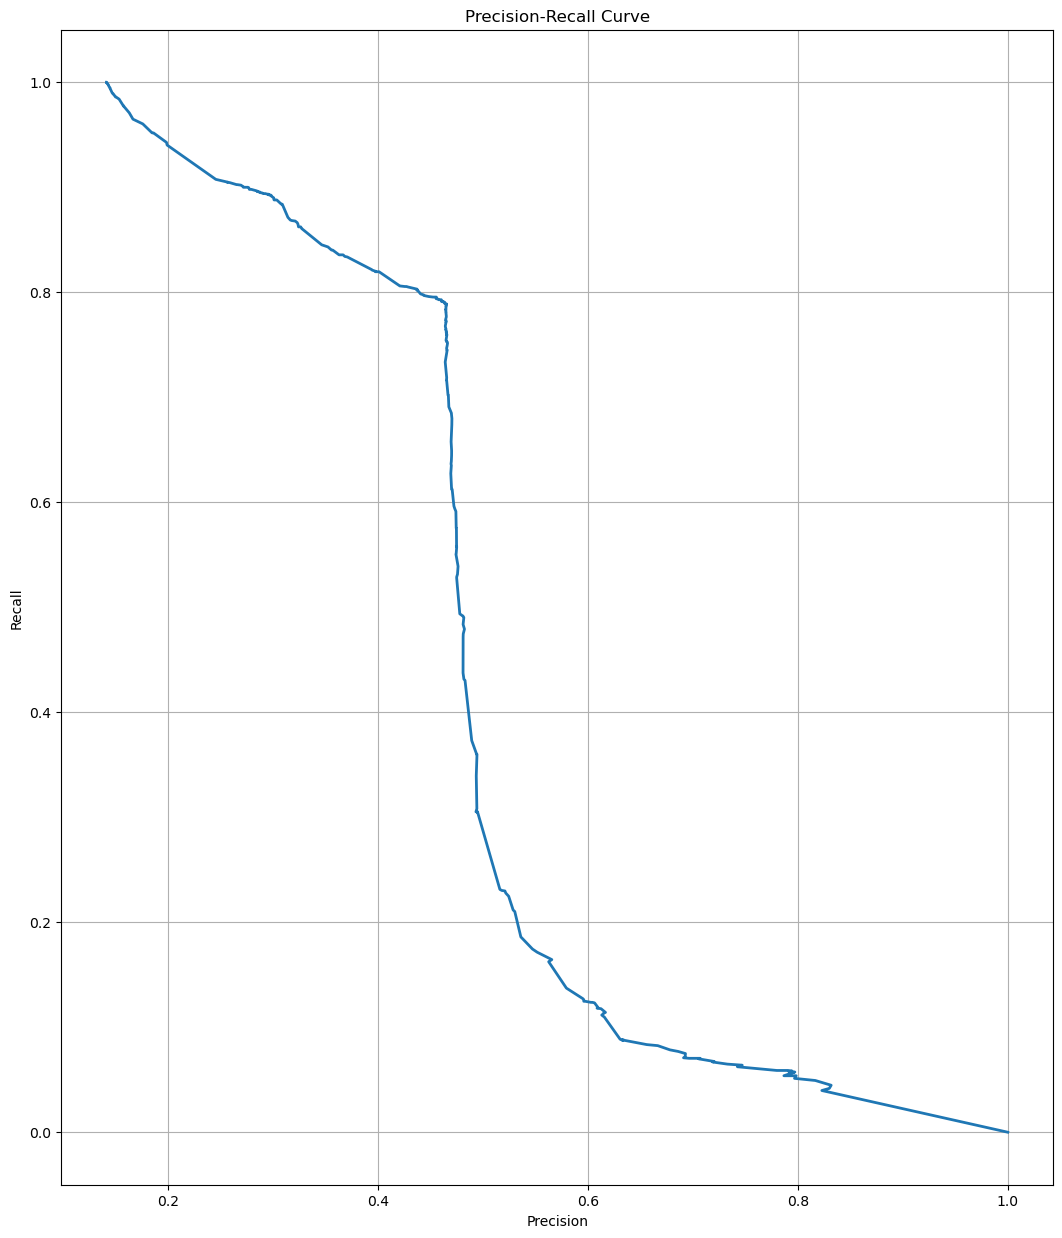

In [26]:
plot_prc(test_data_df.values[:, 0], hpo_raw_preds)

## Clean Up


Delete the model artifacts and other resources to avoid any incurring charges.

**Caution**: We need to manually delete resources created while running the notebook, such as Amazon S3 buckets for model artifacts, training datasets, processing artifacts, and Amazon CloudWatch log groups.


### Delete the Endpoint Created from XGBoost

In [ ]:
predictor_hpo.delete_model()
predictor_hpo.delete_endpoint()